# Я добавила learning curve и ROC Сurve и дополнила код комментариями 

In [99]:
# -*- coding: utf-8 -*-
import re 
import pandas 
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
#from nltk.stem import * 
from nltk.stem.snowball import SnowballStemmer 
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.learning_curve import learning_curve 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import ShuffleSplit
sns.set(style="whitegrid", color_codes=True)
np.random.seed(sum(map(ord, "categorical")))

f = pd.read_csv('D:/HSE_2016-2017/progamming/HW_Bayes/SMSSpamCollection', sep='\t',
                           names=["label", "message"])
f.head()

C:\Anaconda3\lib\site-packages\sklearn\learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
'''Посчитаем соотношение спама к нормальным сообщениям:'''
ham = 0
spam = 0
ham_arr = []
spam_arr = []
for line in f['label']:
    if "ham" in line:
        ham += 1
    if 'spam' in line:
        spam += 1
print('ham: ', ham, 'spam: ', spam)

ham:  4825 spam:  747


Как мы видим, выборка не сбалансирована. Спама почти в 7 раз меньше.

In [97]:
from nltk import word_tokenize
import re 
import itertools
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from nltk.stem.snowball import SnowballStemmer 
from nltk.stem import WordNetLemmatizer

tokens = [word_tokenize(i) for i in f]
'''Токенизация с удалением знаков препинания:'''
def tokenize(text):
    text = text.lower()
    text = re.sub("[,;':.?!]", '', text)
    return word_tokenize(text)  

'''Знаки препинания считаются токенами:'''
def p_tokenize(text):
    text = text.lower()
    return wordpunct_tokenize(text) 

'''Стемминг. Используем SnowballStemmer '''
def ball_stemming(text):
    stemmer = SnowballStemmer("english") 
    tokens = word_tokenize(text)
    stemmas = [stemmer.stem(token) for token in tokens]
    return stemmas 

'''Лемматизация. Используем WordNetLemmatizer'''
def lemming(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmas

'''Очистка от стоп-слов'''
def stop_words(text):
    stopWords = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered = [w for w in tokens if not w in stopWords] 
    return filtered 
spam_arr = f[f['label']=='spam']
#print([spam_arr])
ham_arr = f[f['label']=='ham']


'''Нормализуем выборку. Сделаем соотношение спама к не-спаму примерно 8:9.''' 
''' Всего 747 сообщений спама. Возьмем 373  - примерно половину из них.'''
train = pd.concat([spam_arr[:373], ham_arr[:420]], ignore_index = True)
test = pd.concat([spam_arr[373:], ham_arr[420:]], ignore_index = True)

msg_train = list(train['message'])
label_train = np.array(train['label'])
msg_test = list(test['message'])
label_test = np.array(test['label'])
#print(train.groupby('label').describe())
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

'''Создаем матрицу терм-документ,  в параметр analyzer по очереди подставляем все наши функции и смотрим что получается:'''
bow = CountVectorizer(analyzer=tokenize)    
bow.fit_transform(msg_train)
bowed_train = bow.transform(msg_train)
bowed_test = bow.transform(msg_test)

naive_model = MultinomialNB()
naive_model.fit(bowed_train, label_train)
pred = naive_model.predict(bowed_test)
print(classification_report(label_test, pred))
print(confusion_matrix(label_test, pred))

             precision    recall  f1-score   support

        ham       1.00      0.97      0.98      4405
       spam       0.71      0.94      0.81       374

avg / total       0.97      0.96      0.97      4779

[[4258  147]
 [  21  353]]


In [31]:
'''Токенизируем, учитывая знаки препинания '''
bow_p = CountVectorizer(analyzer=p_tokenize)   
 
bow_p.fit_transform(msg_train)
bowed_train = bow_p.transform(msg_train)
bowed_test = bow_p.transform(msg_test)

naive_model_p = MultinomialNB()
naive_model_p.fit(bowed_train, label_train)
pred = naive_model_p.predict(bowed_test)
print(classification_report(label_test, pred))
print(confusion_matrix(label_test, pred))

             precision    recall  f1-score   support

        ham       1.00      0.97      0.99      4405
       spam       0.76      0.95      0.85       374

avg / total       0.98      0.97      0.97      4779

[[4293  112]
 [  17  357]]


Учитывая знаки препинания, классифицирует чуть точнее. 

In [35]:
from nltk.stem.snowball import SnowballStemmer 
'''Стемминг (SnowBallStemmer)'''
bow_s = CountVectorizer(analyzer=ball_stemming)    
bow_s.fit_transform(msg_train)
bowed_train = bow_s.transform(msg_train)
bowed_test = bow_s.transform(msg_test)

naive_model_s = MultinomialNB()
naive_model_s.fit(bowed_train, label_train)
pred = naive_model_s.predict(bowed_test)
print(classification_report(label_test, pred))
print(confusion_matrix(label_test, pred))

             precision    recall  f1-score   support

        ham       1.00      0.97      0.98      4405
       spam       0.73      0.94      0.82       374

avg / total       0.97      0.97      0.97      4779

[[4276  129]
 [  21  353]]


Стемминг работает хуже  - если при токенизации с учётом знаков препинания 112 сообщений ham уходило в спам, то сейчас их уже 129. И если тогда 17 спамовых сообщений распознавались, как ham, то сейчас их уже 21.

In [36]:
from nltk.stem import WordNetLemmatizer
'''Лемматизация (WordnetLemmatizer)'''
bow_l = CountVectorizer(analyzer=lemming)    
bow_l.fit_transform(msg_train)
bowed_train = bow_l.transform(msg_train)
bowed_test = bow_l.transform(msg_test)

naive_model_l = MultinomialNB()
naive_model_l.fit(bowed_train, label_train)
pred = naive_model_l.predict(bowed_test)
print(classification_report(label_test, pred))
print(confusion_matrix(label_test, pred))

             precision    recall  f1-score   support

        ham       1.00      0.96      0.98      4405
       spam       0.65      0.94      0.77       374

avg / total       0.97      0.96      0.96      4779

[[4218  187]
 [  21  353]]


Ещё хуже. Аж 187 хороших сообщений уходят в спам. Попробуем теперь убрать стоп-слова.

In [37]:
from nltk.corpus import stopwords
'''Удаление стоп-слов'''
bow_w = CountVectorizer(analyzer=stop_words)    
bow_w.fit_transform(msg_train)
bowed_train = bow_w.transform(msg_train)
bowed_test = bow_w.transform(msg_test)

naive_model_w = MultinomialNB()
naive_model_w.fit(bowed_train, label_train)
pred = naive_model_w.predict(bowed_test)
print(classification_report(label_test, pred))
print(confusion_matrix(label_test, pred))


             precision    recall  f1-score   support

        ham       0.99      0.95      0.97      4405
       spam       0.59      0.94      0.73       374

avg / total       0.96      0.94      0.95      4779

[[4164  241]
 [  23  351]]


И ещё хуже. Уже в спам ушло 241 нужное письмо.

In [38]:
''' min vs. max document frequency'''
bow_min = CountVectorizer(min_df = 0.3)    
bowed_train = bow_min.fit_transform(msg_train)
bowed_test = bow_min.transform(msg_test)

naive_model_min = MultinomialNB()
naive_model_min.fit(bowed_train, label_train)
pred = naive_model_min.predict(bowed_test)
print(classification_report(label_test, pred))
print(confusion_matrix(label_test, pred))

             precision    recall  f1-score   support

        ham       0.95      0.83      0.89      4405
       spam       0.19      0.47      0.27       374

avg / total       0.89      0.80      0.84      4779

[[3655  750]
 [ 197  177]]


Совсем плохо. В спам уходит аж 750 ham, и 197 спамовых писем наоборот, попадают в ham.

In [45]:
bow_max = CountVectorizer(max_df = 3)    
bowed_train = bow_max.fit_transform(msg_train)
bowed_test = bow_max.transform(msg_test)

naive_model_max = MultinomialNB()
naive_model_max.fit(bowed_train, label_train)
pred = naive_model_max.predict(bowed_test)
print(classification_report(label_test, pred))
print(confusion_matrix(label_test, pred))

             precision    recall  f1-score   support

        ham       0.98      0.93      0.95      4405
       spam       0.49      0.79      0.60       374

avg / total       0.94      0.92      0.93      4779

[[4092  313]
 [  77  297]]


Получше, чем предыдущее, но всё равно плохо. 

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
'''TfIdfVectorizer'''
Tf = TfidfVectorizer()
train_tf = Tf.fit_transform(msg_train)
test_tf = Tf.transform(msg_test)

naive_model_tf = MultinomialNB()
naive_model_tf.fit(train_tf, label_train)
pred = naive_model_tf.predict(test_tf)
print(classification_report(label_test, pred))
print(confusion_matrix(label_test, pred))

             precision    recall  f1-score   support

        ham       0.99      0.98      0.99      4405
       spam       0.77      0.93      0.84       374

avg / total       0.98      0.97      0.97      4779

[[4301  104]
 [  25  349]]


А тут результат значительно лучше. Если же выбирать между токенизацей с удалением знаков препинания,
токенизацией с сохранением знаков препинания, стеммингом и лематизацией,
то наилучший результат покажет токенизация с сохранением знаков препинания
(знак препинания считается за отдельный токен). 

В целом, если говорить о применении классификатора спама и не-спама на практике, то "из двух зол" - 1. ham  попал в спам и 2. спам попал в ham, меньшим будет 1е - когда хорошее письмо попадает в спам. Почему? В первую очередь это не так опасно - всегда можно время от времени заходить в папку со спамом и смотреть, не затерялось ли там что-нибудь нужное. А вот если спамовое сообщение по ошибке не распознается как спам, и попадет в поток хороших нужных писем, то это может очень сильно навредить компьютеру. Так что наш классификатор работает более менее хорошо. 

In [51]:
from sklearn.tree import DecisionTreeClassifier
'''Tree'''
clf = DecisionTreeClassifier()
'''TfIdfVectorizer:'''
clf.fit(train_tf, label_train)
pred = clf.predict(test_tf)
print(classification_report(label_test, pred))
print(confusion_matrix(label_test, pred))
'''CountVectorizer'''
clf.fit(bowed_train, label_train)
pred = clf.predict(bowed_test)
print(classification_report(label_test, pred))
print(confusion_matrix(label_test, pred))

             precision    recall  f1-score   support

        ham       0.98      0.93      0.96      4405
       spam       0.51      0.82      0.63       374

avg / total       0.95      0.92      0.93      4779

[[4110  295]
 [  68  306]]
             precision    recall  f1-score   support

        ham       0.96      0.95      0.96      4405
       spam       0.49      0.57      0.53       374

avg / total       0.93      0.92      0.92      4779

[[4182  223]
 [ 161  213]]


Дерево работает плохо при обоих типах векторизации.

In [52]:
'''Forest'''
forest = RandomForestClassifier()
forest.fit(train_tf, label_train)
pred = forest.predict(test_tf)
print(classification_report(label_test, pred))
print(confusion_matrix(label_test, pred))

             precision    recall  f1-score   support

        ham       0.99      0.98      0.98      4405
       spam       0.80      0.85      0.82       374

avg / total       0.97      0.97      0.97      4779

[[4323   82]
 [  56  318]]


А лес справляется с классификацией в разы лучше дерева, классифицируя и спам и ham  с гораздо большей точностью: 

#  UPD. ТУТ Я ДОБАВИЛА LEARNING CURVES

<module 'matplotlib.pyplot' from 'C:\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

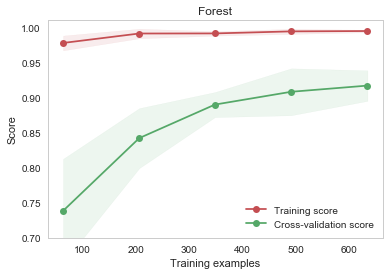

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, learning_curve, ShuffleSplit
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = RandomForestClassifier()
plot_learning_curve(estimator, 'Forest', train_tf.toarray(), label_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)


<module 'matplotlib.pyplot' from 'C:\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

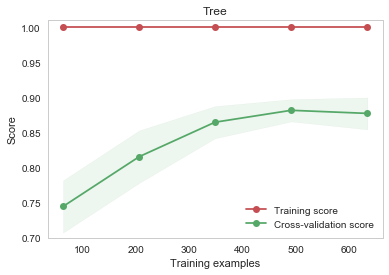

In [56]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = DecisionTreeClassifier()
plot_learning_curve(estimator, 'Tree', train_tf.toarray(), label_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from 'C:\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

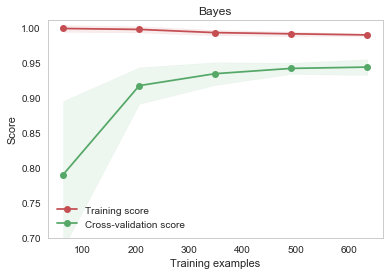

In [58]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = MultinomialNB()
plot_learning_curve(estimator, 'Bayes', train_tf.toarray(), label_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

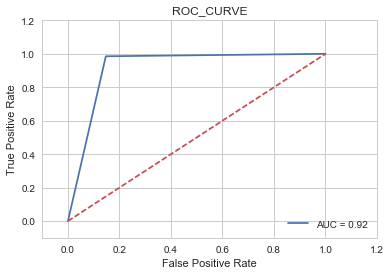

In [81]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt




forest = RandomForestClassifier()
forest.fit(train_tf, label_train)
pred = forest.predict(test_tf)
def ROC_CURVE_GRAPH(clf):
    clf.fit(train_tf, label_train)
    pred = clf.predict(test_tf)
    actual = []
    predictions = []
    for l in pred:
        if l =='ham':
            predictions.append(1)
        elif l =='spam':
            predictions.append(0)
    for l in label_test:
        if l =='ham':
            actual.append(1)
        elif l =='spam':
            actual.append(0)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.title('ROC_CURVE')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

ROC_CURVE_GRAPH(forest)

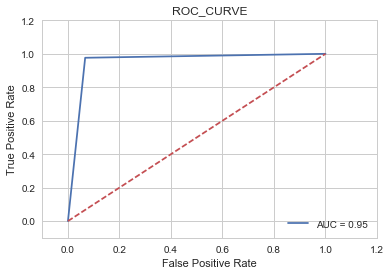

In [84]:
naive_model_tf = MultinomialNB()
naive_model_tf.fit(train_tf, label_train)
pred = naive_model_tf.predict(test_tf)

ROC_CURVE_GRAPH(naive_model_tf)

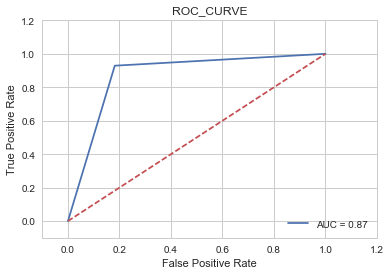

In [86]:
clf = DecisionTreeClassifier()

clf.fit(train_tf, label_train)
pred = clf.predict(test_tf)
ROC_CURVE_GRAPH(clf)

Как мы интерпретируем все эти графики:
Learning curve показывает, что при увеличении объема выборки модель работает лучше (на всех трех графиках обычное обучение остаётся практически неизменным: у леса чуть возрастает вначале, у Байеса наоборот, чуть снижается). На Кросс-валидации обучаемость хорошо растёт у леса, чуть меньше у Байеса, а у дерева чуть ухудшается в конце.
ROC- кривые: Из графиков видно, что качество модели довольно высокое - площадь под кривой большая (однако в данном случае, дерево ведет себя чуть хуже остальных). 

In [98]:
f.head()  

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [104]:
X_train, X_test, y_train, y_test = train_test_split(f['message'], f['label'], test_size = 0.2)
X_train.head()

4385    Thanks honey but still haven't heard anything ...
4442    I'm going 2 orchard now laready me reaching so...
660     88800 and 89034 are premium phone services cal...
1872    Dont know supports ass and srt i thnk. I think...
119     Hmm...my uncle just informed me that he's payi...
Name: message, dtype: object

Колонку с длиной мы уже добавили с самого начала. Добавим ещё признаки.Буквы КАПСОМ:

In [109]:
CAPSLOCK = "ABCDEFJHIJKLMNOPQRSTUVWXYZ"
ARR = []
for word in train['message']:
    CAPSLOCK_COUNTER= 0
    for letter in word:
        #print(letter)
        if letter in CAPSLOCK:
            CAPSLOCK_COUNTER += 1
    ARR.append(CAPSLOCK_COUNTER)
train['CAPSLOCK'] = ARR
train.head()

,label,message,length,CAPSLOCK,numbers
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,10,25
1,spam,FreeMsg Hey there darling it's been 3 week's n...,147,7,4
2,spam,WINNER!! As a valued network customer you have...,157,12,19
3,spam,Had your mobile 11 months or more? U R entitle...,154,14,13
4,spam,"SIX chances to win CASH! From 100 to 20,000 po...",136,17,22


In [110]:
numbers = '1234567890'
nums = []
for word in train['message']:
    num_COUNTER= 0
    for letter in word:
        #print(letter)
        if letter in numbers:
            num_COUNTER += 1
    nums.append(num_COUNTER)
train['numbers'] = nums
train.head()

,label,message,length,CAPSLOCK,numbers
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,10,25
1,spam,FreeMsg Hey there darling it's been 3 week's n...,147,7,4
2,spam,WINNER!! As a valued network customer you have...,157,12,19
3,spam,Had your mobile 11 months or more? U R entitle...,154,14,13
4,spam,"SIX chances to win CASH! From 100 to 20,000 po...",136,17,22


In [119]:
clam = []
for word in train['message']:
    clam_COUNTER= 0
    for letter in word:
        #print(letter)
        if letter == '!':
            clam_COUNTER += 1
    clam.append(clam_COUNTER)
'train['Exclamation marks'] = clam
train.head(7)

,label,message,length,CAPSLOCK,numbers,Exclamation marks,commas
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,10,25,0,0
1,spam,FreeMsg Hey there darling it's been 3 week's n...,147,7,4,2,1
2,spam,WINNER!! As a valued network customer you have...,157,12,19,3,0
3,spam,Had your mobile 11 months or more? U R entitle...,154,14,13,1,0
4,spam,"SIX chances to win CASH! From 100 to 20,000 po...",136,17,22,1,3
5,spam,URGENT! You have won a 1 week FREE membership ...,155,39,20,2,1
6,spam,"XXXMobileMovieClub: To use your credit, click ...",149,20,0,0,1


In [132]:

commas = []
for word in train['message']:
    comma_COUNTER= 0
    for letter in word:
        print(letter)
        if letter == ',':
            comma_COUNTER += 1
    commas.append(comma_COUNTER)
train['commas'] = commas
train.drop(['message', 'domens'], axis=1, inplace=True)


In [128]:
x_labels = ['length', 'CAPSLOCK', 'numbers', 'Exclamation marks', 'commas']
X, y = train[x_labels], train['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train.head()

650     ham
350    spam
118    spam
608     ham
50     spam
Name: label, dtype: object

             precision    recall  f1-score   support

        ham       0.90      0.89      0.89        88
       spam       0.86      0.87      0.87        71

avg / total       0.88      0.88      0.88       159

[[78 10]
 [ 9 62]]


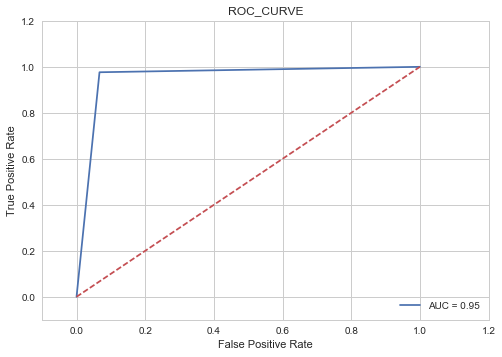

In [137]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
pred = nb.predict(X_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

ROC_CURVE_GRAPH(nb)

И добавив свои фичи, мы видим, что качество получается тоже неплохое

In [141]:


fst = RandomForestClassifier()
fst.fit(X_train, y_train)
pred = fst.predict(X_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))



             precision    recall  f1-score   support

        ham       0.95      0.95      0.95        88
       spam       0.94      0.94      0.94        71

avg / total       0.95      0.95      0.95       159

[[84  4]
 [ 4 67]]


In [ ]:
А Лес классифицирует еще лучше